In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
start = '2014-01-01'
end = '2024-12-31'
stock = 'AAPL'

data = yf.download(stock, start=start, end=end)
data = data[['Close']]

C:\Users\anich\AppData\Local\Temp\ipykernel_10796\1165606241.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [12]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

sequence_length = 60
x, y = create_sequences(scaled_data, sequence_length)

In [13]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [14]:
train_size = int(len(x) * 0.8)
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [15]:
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\anich\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [17]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - loss: 0.0076 - val_loss: 7.0399e-04 - learning_rate: 0.0010
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 6.4107e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 5.8812e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 4.9720e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 5.3799e-04 - val_loss: 8.9436e-04 - learning_rate: 0.0010
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 4.3529e-04 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 4.9247e-04 - val_loss: 9.1911e-04 - learning_rate: 5.0000e-04
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 4.8659e-04 - val_loss: 6.4028e-04 - learning_rate: 5.0000e-04
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 4.362

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step  


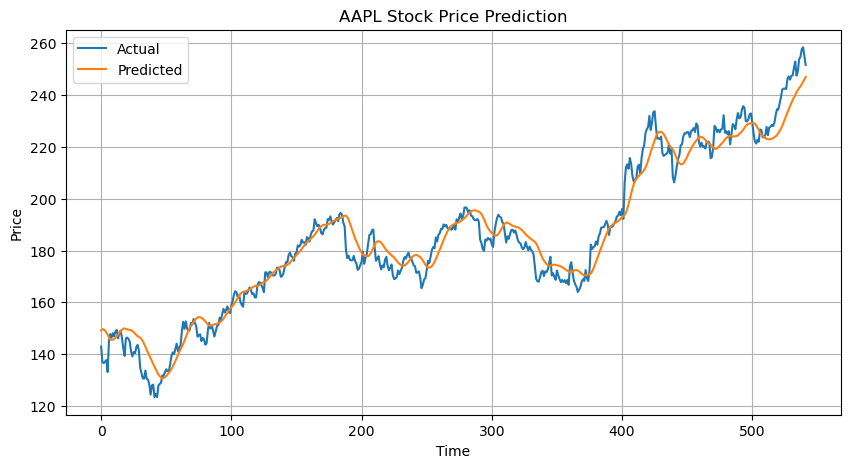

In [18]:
y_pred = model.predict(x_val)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_val_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title(f'{stock} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()